### 🔢 PDG Particle IDs

The `PDG_ID` dictionary maps [PDG (Particle Data Group)](https://pdg.lbl.gov/) Monte Carlo particle identification numbers to their corresponding particle names. These identifiers are widely used in high-energy physics simulations (e.g., MadGraph, Pythia, Delphes) to represent particles in event records.

In [1]:
### PDG Particles ID
PDG_ID = {
    # Quarks
    1: 'down', -1: 'anti-down',
    2: 'up', -2: 'anti-up',
    3: 'strange', -3: 'anti-strange',
    4: 'charm', -4: 'anti-charm',
    5: 'bottom', -5: 'anti-bottom',
    6: 'top', -6: 'anti-top',

    # Leptons
    11: 'electron', -11: 'positron',
    12: 'electron neutrino', -12: 'anti-electron neutrino',
    13: 'muon', -13: 'anti-muon',
    14: 'muon neutrino', -14: 'anti-muon neutrino',
    15: 'tau', -15: 'anti-tau',
    16: 'tau neutrino', -16: 'anti-tau neutrino',

    # Gauge Bosons
    21: 'gluon',
    22: 'photon',
    23: 'Z boson',
    24: 'W+ boson', -24: 'W- boson',

    # Higgs Bosons
    25: 'Higgs (H1^0)',
    35: 'Higgs (H2^0)',
    45: 'Higgs (H3^0)',
    36: 'Pseudoscalar Higgs (A1^0)', -36: 'anti-Pseudoscalar Higgs (A1^0)',
    46: 'Pseudoscalar Higgs (A2^0)', -46: 'anti-Pseudoscalar Higgs (A2^0)',
    37: 'Charged Higgs (H+)', -37: 'Charged Higgs (H-)',

    # Graviton
    39: 'Graviton'
}

----

In [2]:
### Importing Libraries
import gzip                         # For reading compressed .gz files (e.g., .lhe.gz or .hepmc.gz)
import xml.etree.ElementTree as ET  # For parsing LHE files in XML format
import pyhepmc                      # For reading HEPMC format event files
import uproot                       # For reading ROOT files, typically used with Delphes output
import awkward as ak                # For handling variable-length particle arrays efficiently

### Visualization
import matplotlib.pyplot as plt 

### Calculation
import numpy as np 

-----

## 📂 Reading LHE Files (MadGraph)
**Purpose**: Load and parse parton-level events from MadGraph `.lhe.gz` files.

Includes:
- `read_lhe_file`: Extracts 4-momenta from XML event blocks
- `get_final_state`: Filters final-state particles (status == 1)
- `calc_ll_mass`: Calculates invariant mass $m_{\ell\ell}$ of lepton pairs

In [3]:
def read_lhe_file(file_path):
    with gzip.open(file_path,'rt') as f:
        tree = ET.parse(f)
        root = tree.getroot()

        events = []
        for event in root.findall('.//event'):
            lines = event.text.strip().split("\n")
            event_data = []

            for line in lines[1:]:                              # Meta Data 건너뛰기
                tokens = line.strip().split()
                if len(tokens) < 10:
                    continue
                pid = int(tokens[0])
                status = int(tokens[1])
                px, py, pz, E = map(float, tokens[6:10])        # 4-momentum 추출
                event_data.append((pid, status, px, py, pz, E))

            events.append(event_data)

    return events

def get_final_state(event):
    final_state = [p for p in event if p[1]==1]
    return final_state

def calc_ll_mass(events):
    masses = list()
    for event in events:
        final_state = get_final_state(event)
        l1 = final_state[0]
        l2 = final_state[1]
        
        px = l1[2] + l2[2]
        py = l1[3] + l2[3]
        pz = l1[4] + l2[4]
        E = l1[5] + l2[5]

        m_ll = np.sqrt(E**2 - (px**2 + py**2 + pz**2))
        masses.append(m_ll)

    return masses

## 💥 Reading HEPMC Files (Pythia8)
**Purpose**: Read hadronized event data and compute invariant masses from Pythia output.

Includes:
- `invariant_mass`: Computes $m_{\ell\ell}$ from 4-momenta
- `get_final_state_particles`: Filters final-state particles (status == 1)
- `get_lepton_pairs`: Selects opposite-sign same-flavor (OSSF) lepton pairs
- `calc_ll_mass_from_hepmc`: Full workflow from HEPMC to $m_{\ell\ell}$

In [4]:
def invariant_mass(p1, p2):
    """
    Compute the invariant mass of two particles given their 4-momenta.
    """
    E = p1.e + p2.e
    px = p1.px + p2.px
    py = p1.py + p2.py
    pz = p1.pz + p2.pz
    m2 = E**2 - (px**2 + py**2 + pz**2)
    if m2 > 0:
        return np.sqrt(m2)
    else:
        return None

def get_final_state_particles(event):
    """
    Return a list of final state (status == 1) particles from a HEPMC event.
    """
    return [p for p in event.particles if p.status == 1]

def get_lepton_pairs(particles):
    """
    Return all opposite-sign same-flavor lepton pairs (e, mu) from a list of particles.
    """
    leptons = [p for p in particles if abs(p.pid) in [11, 13]]  # electrons and muons only
    pairs = []
    for i in range(len(leptons)):
        for j in range(i + 1, len(leptons)):
            l1, l2 = leptons[i], leptons[j]
            if l1.pid * l2.pid < 0 and abs(l1.pid) == abs(l2.pid):  # opposite sign same flavor
                pairs.append((l1, l2))
    return pairs

def calc_ll_mass_from_hepmc(file_path):
    """
    Read HEPMC file and compute invariant mass for lepton pairs in each event.
    """
    masses = []
    with pyhepmc.open(file_path) as f:
        for event in f:
            final_state = get_final_state_particles(event)
            lepton_pairs = get_lepton_pairs(final_state)
            for l1, l2 in lepton_pairs:
                mass = invariant_mass(l1.momentum, l2.momentum)
                if mass is not None:
                    masses.append(mass)
    return masses


## 🔍 Reading ROOT Files (Delphes)
**Purpose**: Simulate detector-level observables using Delphes output.

Includes:
- `get_leptons_from_delphes`: Extracts and combines electron/muon candidates
- `calc_ll_mass_from_delphes`: Computes invariant mass from detector-level objects

Reconstructs 4-momentum using $(p_T, \eta, \phi, m)$.

In [5]:
def get_leptons_from_delphes(tree):
    """
    Extracts electrons and muons from the Delphes ROOT tree and combines them into unified lepton objects.
    Returns a list of events, where each event is a list of lepton dictionaries.
    """
    electron = tree.arrays(["Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.Charge"], library="ak")
    muon     = tree.arrays(["Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.Charge"], library="ak")

    events = []

    for i in range(len(electron["Electron.PT"])):
        leps = []

        for j in range(len(electron["Electron.PT"][i])):
            leps.append({
                "pt": electron["Electron.PT"][i][j],
                "eta": electron["Electron.Eta"][i][j],
                "phi": electron["Electron.Phi"][i][j],
                "charge": electron["Electron.Charge"][i][j],
                "mass": 0.000511,  # electron mass [GeV]
                "flavor": "e"
            })

        for j in range(len(muon["Muon.PT"][i])):
            leps.append({
                "pt": muon["Muon.PT"][i][j],
                "eta": muon["Muon.Eta"][i][j],
                "phi": muon["Muon.Phi"][i][j],
                "charge": muon["Muon.Charge"][i][j],
                "mass": 0.10566,  # muon mass [GeV]
                "flavor": "mu"
            })

        events.append(leps)

    return events

def calc_ll_mass_from_delphes(file_path):
    """
    Computes invariant mass of same-flavor, opposite-charge lepton pairs from Delphes ROOT output.
    """
    file = uproot.open(file_path)
    tree = file["Delphes;1"]

    events = get_leptons_from_delphes(tree)
    masses = []

    for leps in events:
        for i in range(len(leps)):
            for j in range(i + 1, len(leps)):
                l1 = leps[i]
                l2 = leps[j]
                if l1["flavor"] == l2["flavor"] and l1["charge"] * l2["charge"] < 0:
                    # reconstruct 4-momenta
                    px1 = l1["pt"] * np.cos(l1["phi"])
                    py1 = l1["pt"] * np.sin(l1["phi"])
                    pz1 = l1["pt"] * np.sinh(l1["eta"])
                    E1  = np.sqrt(px1**2 + py1**2 + pz1**2 + l1["mass"]**2)

                    px2 = l2["pt"] * np.cos(l2["phi"])
                    py2 = l2["pt"] * np.sin(l2["phi"])
                    pz2 = l2["pt"] * np.sinh(l2["eta"])
                    E2  = np.sqrt(px2**2 + py2**2 + pz2**2 + l2["mass"]**2)

                    E = E1 + E2
                    px = px1 + px2
                    py = py1 + py2
                    pz = pz1 + pz2

                    m2 = E**2 - px**2 - py**2 - pz**2
                    if m2 > 0:
                        masses.append(np.sqrt(m2))

    return masses

-----

### MadGraph5 result(Patron-Level Simulation)

In [6]:
# MadGraph5 result
file_path = "./Data/mg5_output.lhe.gz"
events = read_lhe_file(file_path)
masses = calc_ll_mass(events) 

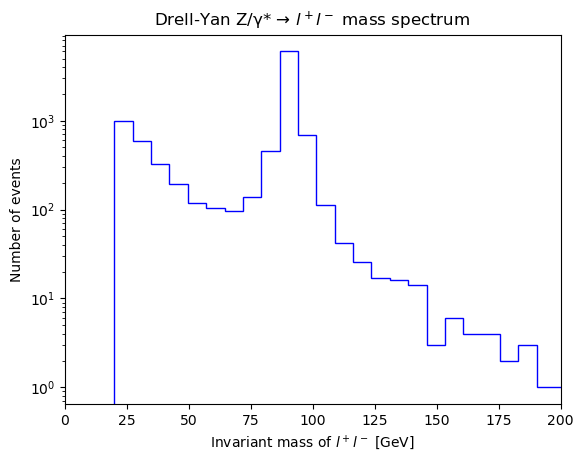

In [7]:
plt.hist(masses, bins = 75, histtype='step', color='blue', label = 'MG5 Simulation')
plt.xlabel("Invariant mass of $l^+ l^−$ [GeV]")
plt.ylabel("Number of events")
plt.title("Drell-Yan Z/γ* → $l^+ l^−$ mass spectrum")
plt.xlim(0,200)
plt.yscale('log')

-----

### Pythia8 result(Shower Level Simulation)

In [8]:
file_path = './Data/pythia8_output.hepmc.gz'
m_ll_pythia = calc_ll_mass_from_hepmc(file_path)

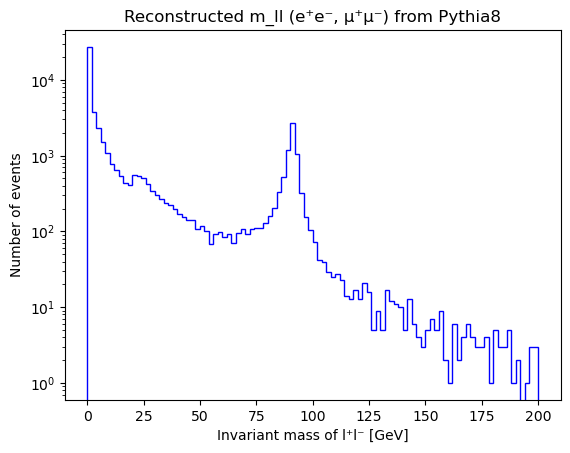

In [13]:
plt.hist(m_ll_pythia, bins=100, range=(0, 200), histtype='step', color='blue')
plt.xlabel("Invariant mass of l⁺l⁻ [GeV]")
plt.ylabel("Number of events")
plt.title("Reconstructed m_ll (e⁺e⁻, μ⁺μ⁻) from Pythia8")
plt.yscale('log')
plt.show()

-----

### Delphes result(especially from CMS card / Detector Level Simulation)

In [10]:
file_path = "./Data/delphes_output.root"
m_ll_delphes = calc_ll_mass_from_delphes(file_path)

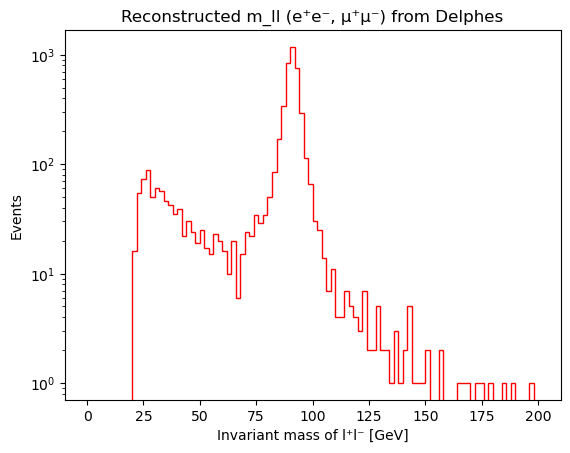

In [11]:
plt.hist(m_ll_delphes, bins=100, range=(0, 200), histtype='step', color='red')
plt.yscale('log')
plt.xlabel("Invariant mass of l⁺l⁻ [GeV]")
plt.ylabel("Events")
plt.title("Reconstructed m_ll (e⁺e⁻, μ⁺μ⁻) from Delphes")
plt.show()

---

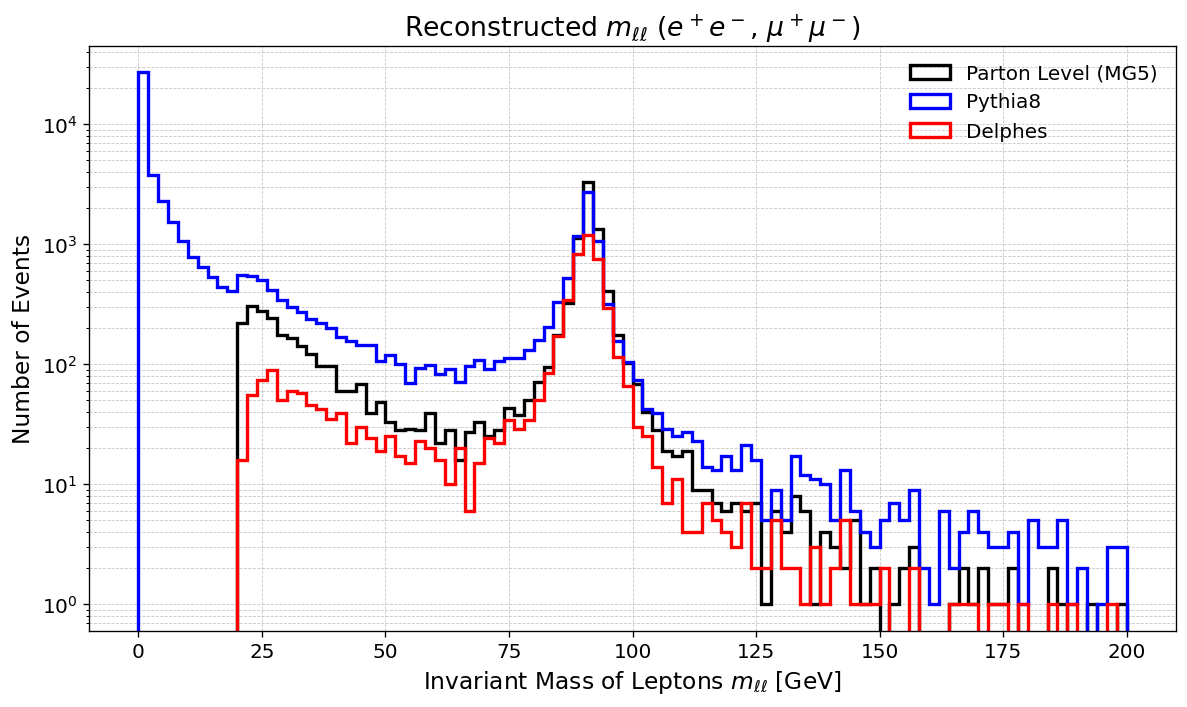

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6), dpi=120)

# Plot histograms
plt.hist(masses, bins=100, range=(0, 200), histtype='step', linewidth=2, color='black', label=r"Parton Level (MG5)")
plt.hist(m_ll_pythia, bins=100, range=(0, 200), histtype='step', linewidth=2, color='blue', label=r"Pythia8")
plt.hist(m_ll_delphes, bins=100, range=(0, 200), histtype='step', linewidth=2, color='red', label=r"Delphes")

# Log scale for y-axis
plt.yscale('log')

# Labels and title
plt.xlabel(r"Invariant Mass of Leptons $m_{\ell\ell}$ [GeV]", fontsize=14)
plt.ylabel(r"Number of Events", fontsize=14)
plt.title(r"Reconstructed $m_{\ell\ell}$ ($e^+e^-$, $\mu^+\mu^-$)", fontsize=16)

# Grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper right', frameon=False)

# Ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


## Invariant Mass Distribution of Lepton Pairs ($m_{\ell\ell}$)

This plot compares the reconstructed invariant mass distributions of same-flavor opposite-sign lepton pairs ($e^+e^-$ and $\mu^+\mu^-$) at different simulation stages:

- **Parton Level (MG5)** – Black line  
- **Hadron Level (Pythia8)** – Blue line  
- **Detector Level (Delphes)** – Red line  

### 🔍 Key Observations

- A **clear Z boson resonance peak** appears around **91 GeV** in all three distributions, confirming correct Drell-Yan event generation and reconstruction.
- The number of events decreases significantly after Delphes, due to **detector effects**, **acceptance cuts**, and **reconstruction inefficiencies**.
- At low mass regions ($m_{\ell\ell} < 50$ GeV), **Pythia8 shows more activity**, likely from background contributions or initial/final state radiation (ISR/FSR).
- The difference between **Pythia8** and **Delphes** illustrates the **impact of detector resolution and efficiency** on physics observables.

### 💡 Conclusion

This comparison demonstrates how each stage in the simulation pipeline—parton-level, hadronization, and detector simulation—affects the reconstruction of physical quantities. Understanding these differences is essential for designing analysis cuts and estimating realistic signal efficiencies.
